# Next-word Generator for the Linux Kernel C code dataset


## Imports and Initial Configuration

In [10]:
import torch
import torch.nn.functional as F
from torch import nn
import os
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import re
import json
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Display PyTorch version and set device
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset directory
dataset_dir = os.path.join(os.getcwd(), 'datasets')


PyTorch Version: 2.5.0+cu124
Using device: cuda


### Tokenizing C Code and Removing Comments

This cell defines two functions to process and tokenize C code: `remove_multiline_comments` and `tokenize_c_code`. 

- **`remove_multiline_comments`**: 
    - This function removes all multiline comments (i.e., `/* ... */`) from the input code using regular expressions.
    - It uses the `re.DOTALL` flag to match comments across multiple lines.

- **`tokenize_c_code`**:
    - This function takes a filename containing C code, reads and processes the code, and outputs a list of tokens.
    - **Preprocessing Steps**:
        - Reads the file and removes any multiline comments with `remove_multiline_comments`.
        - Removes single-line comments using a regular expression.
    - **Token Specification**:
        - The function defines a list `token_specification` that includes patterns for various C components (e.g., keywords, operators, data types).
        - Each token pattern is defined as a tuple with the token type and its regex pattern.
    - **Token Extraction**:
        - All patterns are compiled into a single regex, which is matched iteratively through the code to extract tokens.
        - Special tokens (`\s` for whitespace and `\n` for newlines) are explicitly added to preserve structure.
    - **Output**:
        - Returns a list of token values, where newlines are represented as `'\n'` tokens, and spaces as `'\s'`.


In [11]:

def remove_multiline_comments(code):
    """
    Removes multiline comments from C code.
    """
    multiline_comment_pattern = re.compile(r'/\*.*?\*/', re.DOTALL)
    code = re.sub(multiline_comment_pattern, '', code)
    return code

def tokenize_c_code(filename):
    """
    Tokenizes C code into a list of tokens, returning only the token values as strings.
    Newlines are represented explicitly as '\n' tokens.
    """
    # Remove multiline comments
    filepath = os.path.join(dataset_dir, filename)
    with open(filepath, encoding='utf-8') as file:
        code = file.read()
        
    code = remove_multiline_comments(code)
    
    # Remove single-line comments
    code = re.sub(r'//.*', '', code)
    
    # Token patterns for various C components
    token_specification = [
        ('INCLUDE', r'#include'),                             # Capture #include separately
        ('HEADER',  r'<[^>]+>'),                              # Capture the header file within angle brackets
        ('PREPROCESSOR', r'#\s*(define|ifdef|ifndef|endif)'), # Other preprocessor directives
        ('MACRO', r'#\s*define\s+[^\n]+'),                    # Macro definitions
        ('KEYWORD', r'\b(auto|break|case|char|const|continue|default|do|double|else|enum|extern|'
                    r'float|for|goto|if|inline|int|long|register|restrict|return|short|signed|sizeof|'
                    r'static|struct|switch|typedef|union|unsigned|void|volatile|while)\b'),  # Keywords
        ('TYPE', r'\b(int|char|float|double|void|short|long)\b'),  # Data types
        ('IDENTIFIER', r'\b[A-Za-z_][A-Za-z0-9_]*\b'),            # Identifiers (variable and function names)
        ('NUMBER', r'\b\d+(\.\d+)?\b'),                           # Numeric literals (integer or floating-point)
        ('STRING_LITERAL', r'"(?:\\.|[^"\\])*"'),                 # String literals with escaped characters
        ('CHAR_LITERAL', r"'(?:\\.|[^'\\])'"),                    # Character literals with escaped characters
        ('OPERATOR', r'==|!=|<=|>=|->|&&|\|\||\+\+|--|'
                     r'[+\-*/%=&|<>!~^]'),                        # Multi-character and single-character operators
        ('DELIMITER', r'[;:,.\[\]\(\)\{\}]'),                     # Delimiters
        ('NEWLINE', r'\n'),                                       # Newlines as '\n' tokens
        ('WHITESPACE', r'[ \t]+'),                                # Skip spaces and tabs
        ('MISMATCH', r'.'),                                       # Any other character (error handling)
    ]
    
    # Compile all patterns into a single regex
    tok_regex = '|'.join('(?P<%s>%s)' % pair for pair in token_specification)
    get_token = re.compile(tok_regex).match

    tokens = []
    pos = 0
    mo = get_token(code)
    
    while mo is not None:
        kind = mo.lastgroup
        value = mo.group()

        # Add only token values to the tokens list, treating newlines as '\n'
        if kind == 'WHITESPACE':
            tokens.append('\s')  # Explicitly add newline character
        elif kind == 'NEWLINE':
            tokens.append('\n')  # Explicitly add newline character
        elif kind == 'MISMATCH':
            # Handle unexpected characters if needed (log or raise an error)
            pass
        else:
            tokens.append(value)  # Append only the token value
        
        pos = mo.end()
        mo = get_token(code, pos)
    
    return tokens

<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Nishchay\AppData\Local\Temp\ipykernel_28356\3980535058.py:60: SyntaxWarning: invalid escape sequence '\s'
  tokens.append('\s')  # Explicitly add newline character


### Generating Unique Token Mappings

The `unique_tokens` function generates unique token mappings from a list of tokens produced by the tokenizer.

- **Input**:
    - A list of tokens that may contain duplicates.
  
- **Output**:
    - **Vocabulary (`vocab`)**: A sorted list of unique tokens.
    - **Mappings**:
        - `stoi` (String-to-Index): A dictionary that maps each token in `vocab` to a unique index.
        - `itos` (Index-to-String): A dictionary that maps each index back to its corresponding token.
  
- **Special Tokens**:
    - Adds a special `<UNK>` token at the start of `stoi` to represent unknown tokens in future operations.


In [12]:
def unique_tokens(tokens: list):
    """
    Generates unique token mappings from a list of tokens.
    Includes <UNK> token for unknown tokens.
    """
    # Convert to set to get unique tokens, then back to sorted list
    vocab = sorted(set(tokens))
    
    # Initialize stoi with the <UNK> special token
    special_tokens = ['<UNK>']
    stoi = {token: i + 1 for i, token in enumerate(special_tokens)}
    
    # Add remaining unique vocabulary tokens, starting from the next available index
    next_index = len(stoi) + 1
    for token in vocab:
        if token not in stoi:
            stoi[token] = next_index
            next_index += 1
    
    # Create the itos mapping from updated stoi
    itos = {i: s for s, i in stoi.items()}
    
    return vocab, stoi, itos


### Preparing Data for Model Training

The `prepare_data` function creates input-output pairs from a list of tokens, which are then used to train a language model.

- **Input**:
    - `tokens`: A list of tokens.
    - `block_size`: The context window size, specifying how many tokens each input sequence will contain.
    - `stoi`: The string-to-index mapping for tokens.

- **Output**:
    - Tensors `X` and `Y` for training:
        - `X` contains sequences of `block_size` tokens as context.
        - `Y` contains the next token following each context as the target.
  
- **Process**:
    - Generates `X` and `Y` by iterating over the `tokens` list and creating context-target pairs.
    - Converts each token in the context and target to its corresponding index using `stoi`, with unknown tokens mapped to `<UNK>`.

- **Data Conversion**:
    - `X` and `Y` are converted into PyTorch tensors for use in model training.


In [13]:
def prepare_data(tokens: list, block_size: int, stoi):
    """
    Prepares input-output pairs for training from a list of tokens.
    Each input consists of `block_size` tokens, and the target is the next token.
    Unknown tokens are mapped to the <UNK> index.
    """
    X, Y = [], []
    
    # Define the <UNK> token
    unk_token = '<UNK>'
    unk_idx = stoi.get(unk_token, len(stoi) + 1)  # Get or add <UNK> index if not in stoi

    # Generate input-output pairs
    for i in range(block_size, len(tokens)):
        context = tokens[i-block_size:i]
        target = tokens[i]
        
        # Convert context and target to indices, mapping unknown tokens to <UNK>
        context_ix = [stoi.get(token, unk_idx) for token in context]
        target_ix = stoi.get(target, unk_idx)
        
        X.append(context_ix)
        Y.append(target_ix)
    
    # Convert lists to tensors
    X = torch.tensor(X, dtype=torch.long).to(device)
    Y = torch.tensor(Y, dtype=torch.long).to(device)
    
    return X, Y


## Data Cleaning and Preparation
We clean the text, build the vocabulary, and prepare the data for training.

In [14]:

# Clean the text from the dataset
text = tokenize_c_code('linux.txt')

# Extract unique words and create mappings
vocab, stoi, itos = unique_tokens(text)

# Add the <UNK> token to itos
itos[stoi['<UNK>']] = '<UNK>'


## Training variants of models:
- Embedding size (embedding_dim): 64, 128
- Context window size (block size): 5, 10, 15
- Activation function: ReLU, Tanh

In [15]:
# Hyperparameter grids
embedding_dims = [64, 128]
block_sizes = [5, 10, 15]
activation_functions = {
    'ReLU': nn.ReLU(),
    'Tanh': nn.Tanh()
}

# Other hyperparameters
hidden_dim = 256
epochs = 100
learning_rate = 0.001
batch_size = 1024  # Adjust if necessary based on dataset size

## Defining the dataloader and model

In [16]:
# Prepare DataLoader for mini-batch gradient descent
def create_data_loader(X, Y, batch_size):
    dataset = TensorDataset(X, Y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Define the NextWord model with a flexible activation function
class NextWord(nn.Module):
    """
    A feedforward neural network with multiple hidden layers for next-word prediction.
    Utilizes a configurable activation function to improve gradient flow.
    """
    def __init__(self, block_size, vocab_size, embedding_dim, hidden_dim, activation_fn):
        super(NextWord, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lin1 = nn.Linear(embedding_dim * block_size, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, hidden_dim)
        self.lin4 = nn.Linear(hidden_dim, hidden_dim)
        self.activation = activation_fn
        self.lin_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embeds = self.embedding(x)  # Shape: (batch_size, block_size, embedding_dim)
        embeds = embeds.view(x.shape[0], -1)  # Flatten: (batch_size, block_size * embedding_dim)
        out = self.activation(self.lin1(embeds))
        out = self.activation(self.lin2(out))
        out = self.activation(self.lin3(out))
        out = self.activation(self.lin4(out))
        return self.lin_out(out)  # Shape: (batch_size, vocab_size)

In [17]:
with open("stoi_c.json", "w") as f:
    json.dump(stoi, f)

with open("itos_c.json", "w") as f:
    json.dump(itos, f)

## Training loop

In [8]:

# To store loss histories and labels for plotting
all_loss_histories = []
all_labels = []

# Iterate over all combinations of hyperparameters
for embedding_dim in embedding_dims:
    for block_size in block_sizes:
        # Prepare data for the current block_size
        X, Y = prepare_data(text, block_size, stoi)
        data_loader = create_data_loader(X, Y, batch_size)
        
        for act_name, act_fn in activation_functions.items():
            print(f"\nTraining model with Embedding Dim: {embedding_dim}, Block Size: {block_size}, Activation: {act_name}")
            
            # Initialize the model
            model = NextWord(
                block_size=block_size,
                vocab_size=len(stoi) + 1,  # +1 for unknown tokens
                embedding_dim=embedding_dim,
                hidden_dim=hidden_dim,
                activation_fn=act_fn
            ).to(device)
            
            # Initialize loss function and optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
            
            # List to store the average loss for each epoch
            loss_history = []
            
            # Training loop with mini-batch gradient descent
            for epoch in range(1, epochs + 1):
                model.train()  # Set model to training mode
                total_loss = 0  # Track total loss for the epoch
                
                for batch_X, batch_Y in data_loader:
                    # Move batches to device
                    batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                    
                    # Forward pass
                    outputs = model(batch_X)
                    loss = loss_fn(outputs, batch_Y)
                    
                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    # Accumulate loss
                    total_loss += loss.item()
                
                # Average loss per epoch
                avg_loss = total_loss / len(data_loader)
                loss_history.append(avg_loss)  # Store the average loss
            
                # Print progress every 100 epochs and at the first epoch
                if epoch % 10 == 0 or epoch == 1:
                    print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")
            
            # Save the model with a unique filename
            model_save_path = f'models/c_nextword_model_bs{block_size}_emb{embedding_dim}_act{act_name}.pth'
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")
            
            # Store loss history and label for plotting
            label = f'Emb={embedding_dim}, BS={block_size}, Act={act_name}'
            all_loss_histories.append(loss_history)
            all_labels.append(label)



Training model with Embedding Dim: 64, Block Size: 5, Activation: ReLU
Epoch 1/100, Loss: 2.7862
Epoch 10/100, Loss: 1.3705
Epoch 20/100, Loss: 1.0948
Epoch 30/100, Loss: 0.9822
Epoch 40/100, Loss: 0.9255
Epoch 50/100, Loss: 0.8943
Epoch 60/100, Loss: 0.8718
Epoch 70/100, Loss: 0.8587
Epoch 80/100, Loss: 0.8459
Epoch 90/100, Loss: 0.8395
Epoch 100/100, Loss: 0.8331
Model saved to models/c_nextword_model_bs5_emb64_actReLU.pth

Training model with Embedding Dim: 64, Block Size: 5, Activation: Tanh
Epoch 1/100, Loss: 2.8317
Epoch 10/100, Loss: 1.4134
Epoch 20/100, Loss: 1.1337
Epoch 30/100, Loss: 1.0205
Epoch 40/100, Loss: 0.9700
Epoch 50/100, Loss: 0.9432
Epoch 60/100, Loss: 0.9246
Epoch 70/100, Loss: 0.9160
Epoch 80/100, Loss: 0.9051
Epoch 90/100, Loss: 0.9000
Epoch 100/100, Loss: 0.8957
Model saved to models/c_nextword_model_bs5_emb64_actTanh.pth

Training model with Embedding Dim: 64, Block Size: 10, Activation: ReLU
Epoch 1/100, Loss: 2.7142
Epoch 10/100, Loss: 1.1771
Epoch 20/100, 

## Plotting losses for all models

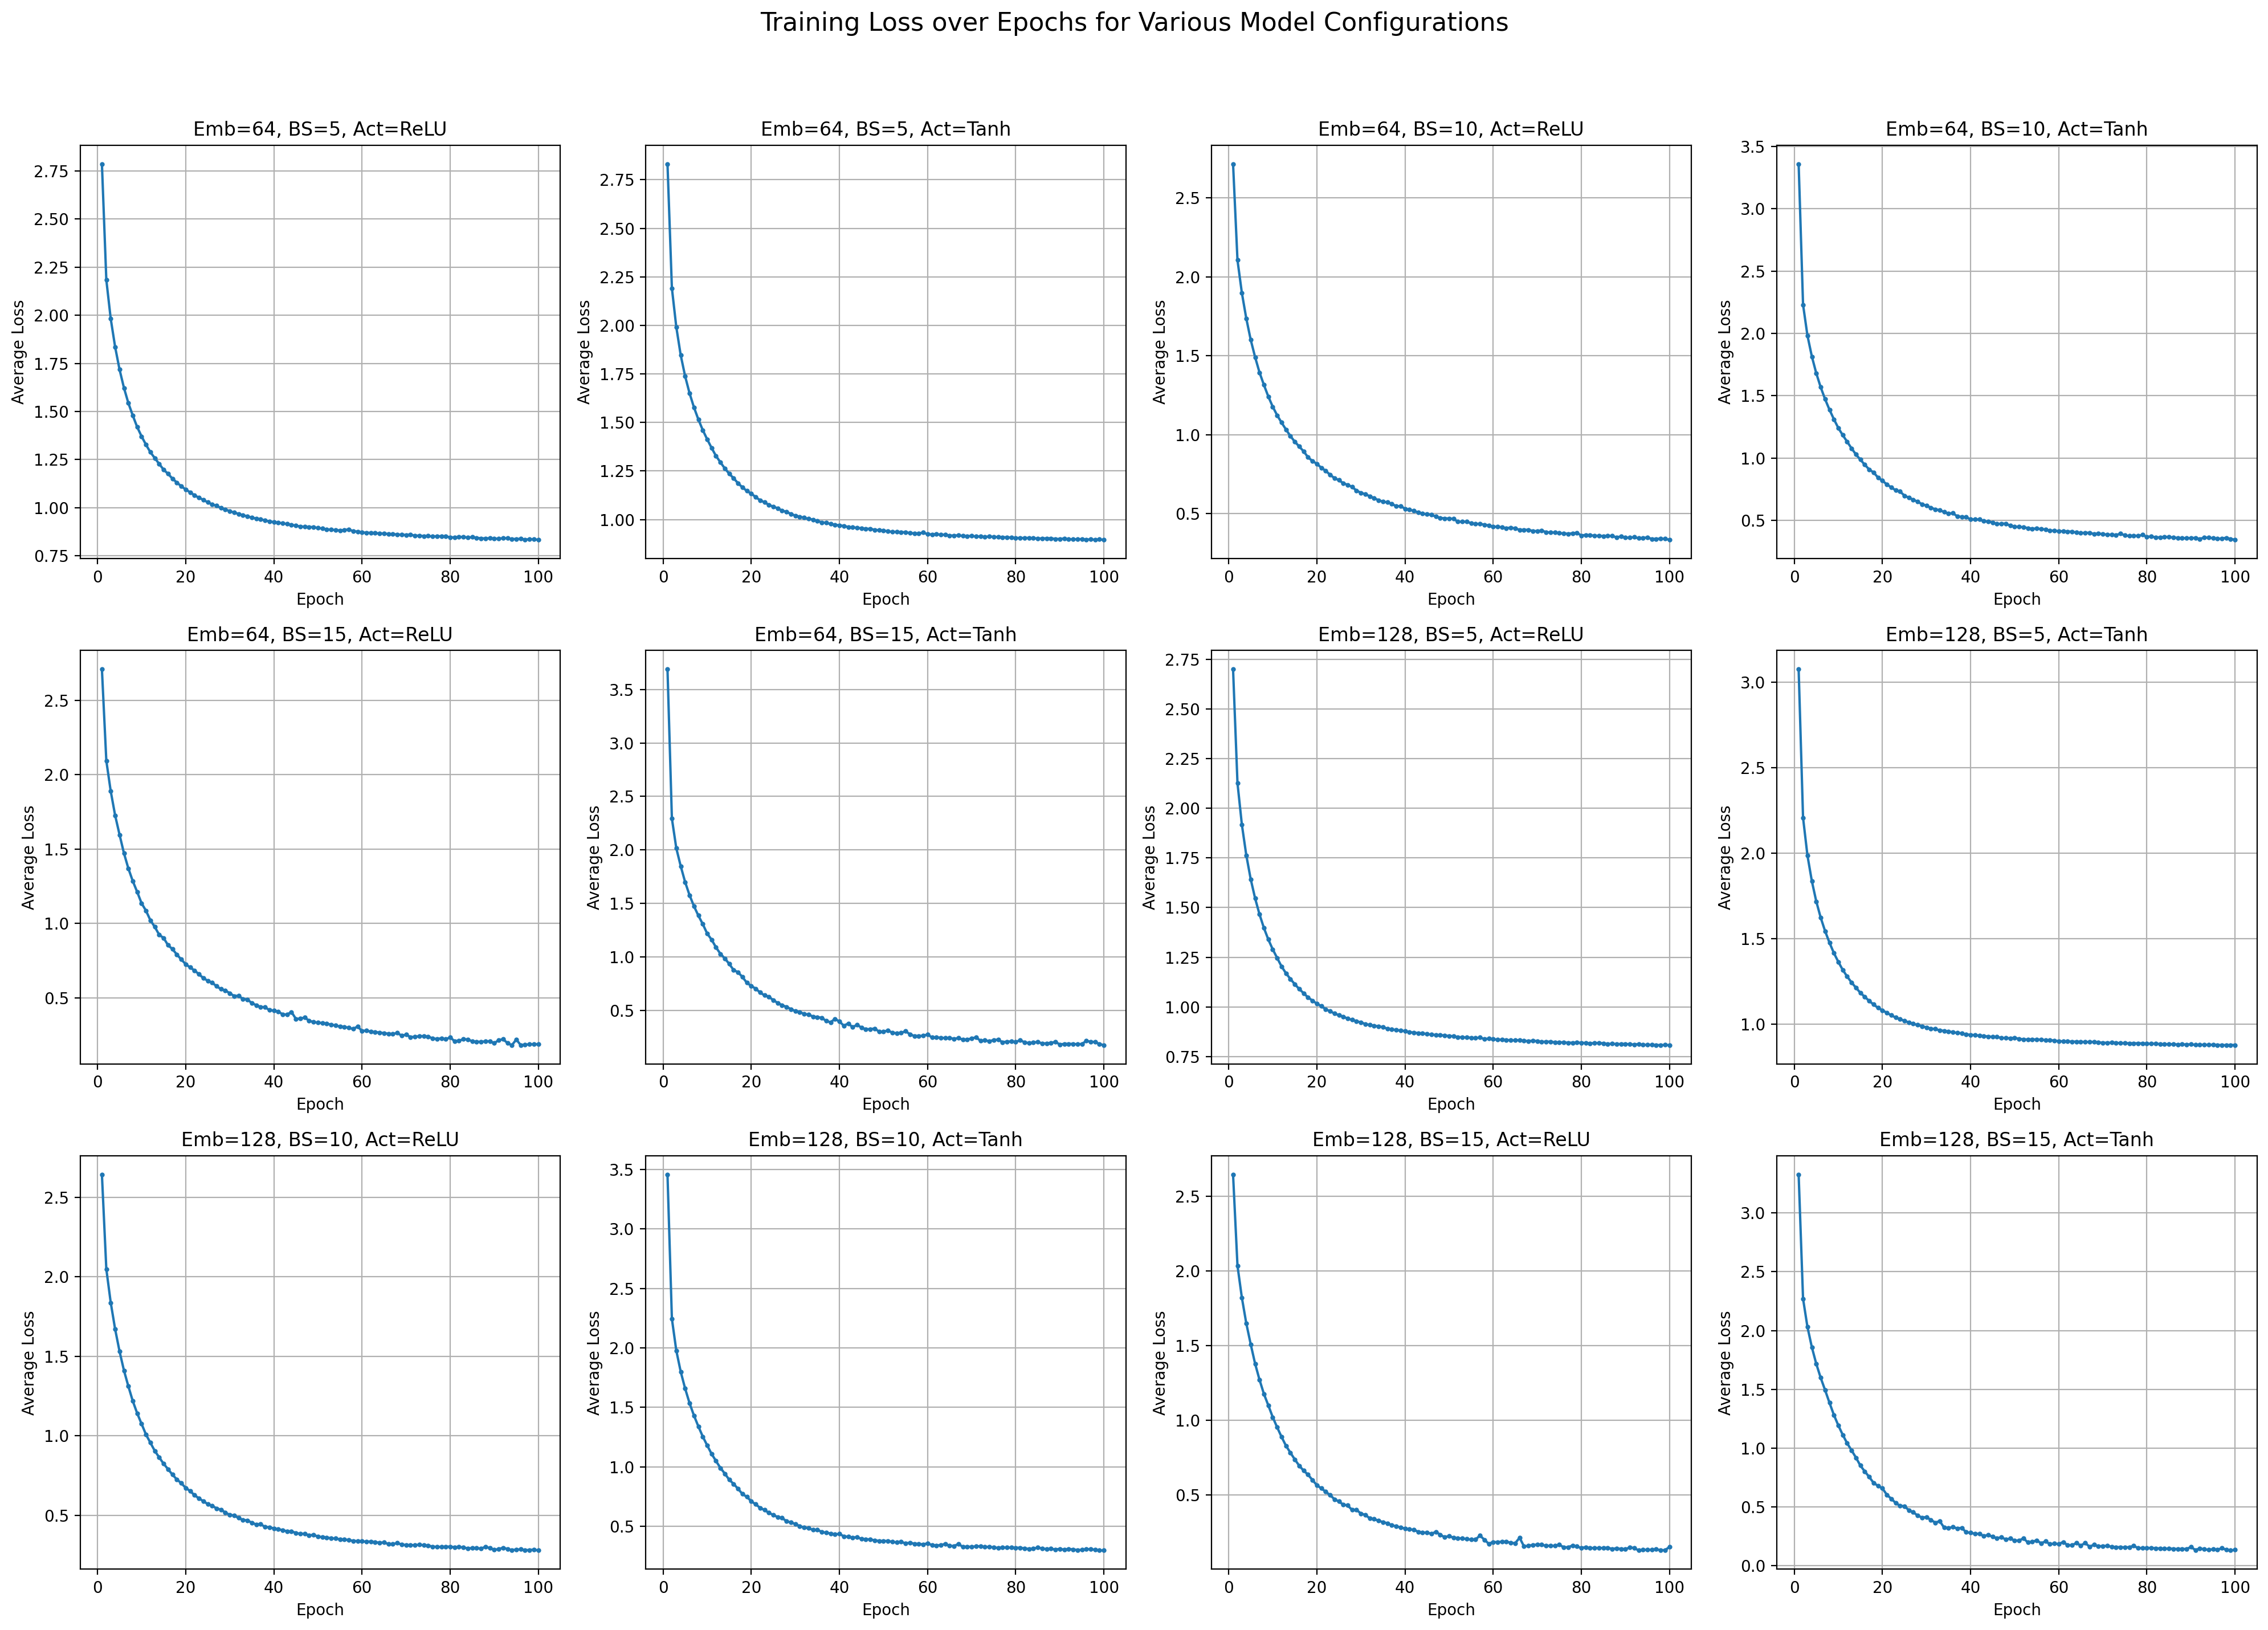

In [9]:

# Plotting the training losses for all models
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Training Loss over Epochs for Various Model Configurations', fontsize=16)

for idx, (loss_history, label) in enumerate(zip(all_loss_histories, all_labels)):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    ax.plot(range(1, epochs + 1), loss_history, marker='o', markersize=2)
    ax.set_title(label)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Average Loss")
    ax.grid(True)

# Hide any unused subplots if total models < subplots
total_models = len(all_loss_histories)
total_subplots = 3 * 4
if total_models < total_subplots:
    for idx in range(total_models, total_subplots):
        row = idx // 4
        col = idx % 4
        fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()